In this chapter, we will cover the Data API, the TFRecord format, and how to create custom preprocessing layers and use the standard Keras ones. We will also take a quick look at a few related projects from TensorFlow’ ecosystem

TF Transform (tf.Transform)

* Makes it possible to write a single preprocessing function that can be run in batch mode on your full training set, before training (to speed it up), and then exported to a TF Function and incorporated into your trained model so that once it is deployed in production it can take care of preprocessing new instances on the fly 

TF Datasets (TFDS)

* Provides a convenient function to download many common datasets of all kinds, including large ones like ImageNet, as well as convenient dataset objects to manipulate them using the Data API

# The Data API

The whole Data API revolves around the concept of a dataset: as you might suspect, this represents a sequence of data items

Usually you will use datasets that gradually read data from disk, but for simplicity **let’s create a dataset entirely in RAM using tf.data.Dataset.from_tensor_slices():**

In [8]:
import tensorflow as tf

X = tf.range(10) # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

The from_tensor_slices() function takes a tensor and creates a tf.data.Dataset whose elements are all the slices of X (along the first dimension), so this dataset contains 10 items: tensors 0, 1, 2, ..., 9. In this case we would have obtained the same dataset if we had used tf.data.Dataset.range(10)

You can simply iterate over a dataset's items like this:

In [9]:
for item in dataset:
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


## Chaining Transformations

Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. Each method returns a new dataset, so you can chain transformations like this (this chain is illustrated in Figure 13-1):

In [10]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
  print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


<p align='center'>
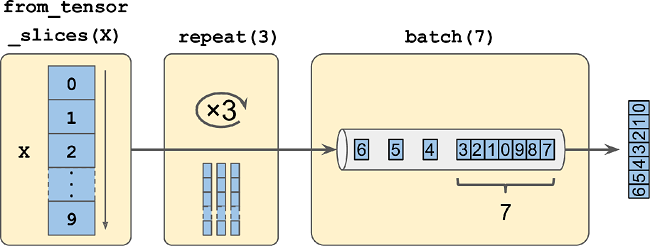
</p>
Figure 13-1. Chaining dataset transformations

In this example, we first call the repeat() method on the original dataset, and it returns a new dataset that will repeat the items of the original dataset three times

Of course, this will not copy all the data in memory three times! (If you call this method with no arguments, the new dataset will repeat the source dataset forever, so the code that iterates over the dataset will have to decide when to stop)

Then we call the batch() method on this new dataset, and again this creates a new dataset. **This one will group the items of the previous dataset in batches of seven items**

Finally, we iterate over the items of this final dataset. As you can see, the batch() method had to output a final batch of size two instead of seven, but you can call it with drop_remainder=True if you want it to drop this final batch so that all batches have the exact same size

The dataset methods do not modify datasets, they create new ones, so make sure to keep a reference to these new datasets

You can also transform the items by calling the map() method. For example, this creates a new dataset with all items doubled:

In [11]:
dataset = dataset.map(lambda x: x * 2)

for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


**This function is the one you will call to apply any preprocessing you want to your data**. Sometimes this will include computations that can be quite intensive, such as reshaping or rotating an image, so you will usually want to spawn multiple threads to speed things up: it’s as simple as setting the num_parallel_calls argument

Note that the function you pass to the method must be convertible to a TF Function map()

While the map() method applies a transformation to each item, the apply() method applies a transformation to the dataset as a whole

For example, the following code applies the unbatch() function to the dataset. Each item in the new dataset will be a single integer tensor instead of a batch of seven integers:

In [12]:
#dataset = dataset.apply(tf.data.experimental.unbatch()) # Now deprecated
dataset = dataset.unbatch()

It is also possible to simply **filter the dataset using the filter() method:**

In [13]:
dataset = dataset.filter(lambda x: x < 10)

**You will often want to look at just a few items from a dataset. You can use the take() method for that:**

In [14]:
for item in dataset.take(3):
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


## Shuffling the Data

Gradient Descent works best when the instances in the training set are independent and identically distributed. A simple way to ensure this is to shuffle the instances, using the shuffle() method

**It will create a new dataset that will start by filling up a buffer with the first items of the source dataset. Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset**

You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective. Just don’t exceed the amount of RAM you have, and even if you have plenty of it, there’s no need to go beyond the dataset’s size

ou can provide a random seed if you want the same random order every time you run your program. For example, the following code creates and displays a dataset containing the integers 0 to 9, repeated 3 times, shuffled using a buffer of size 5 and a random seed of 42, and batched with a batch size of 7:

In [18]:
tf.random.set_seed(42)

dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
  print(item)

tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)
tf.Tensor([6 9], shape=(2,), dtype=int64)


If you call repeat() on a shuffled dataset, by default it will generate a new order at every iteration. This is generally a good idea, but if you prefer to reuse the same order at each iteration (e.g., for tests or debugging), you can set reshuffle_each_iteration=False

For a large dataset that does not fit in memory, this simple shuffling buffer approach may not be sufficient, since the buffer will be small compared to the dataset

One solution is to shuffle the source data itself. Even if the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data’s order)

**To shuffle the instances some more, a common approach is to split the source data into multiple files, then read them in a random order during training**

To avoid this you can pick multiple files randomly and read them simultaneously, interleaving their records. Then on top of that you can add a shuffling buffer using the shuffle() method

### Interleaving lines from multiple files

First, let’s suppose that you’ve loaded the California housing dataset, shuffled it, and split it into a training set, a validation set, and a test set



In [28]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

Then you split each set into many CSV files that each look like this (each row contains eight input features plus the target median house value):

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [29]:
import numpy as np
import os

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [30]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [32]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


Let’s also suppose train_filepaths contains the list of training file paths (and you also have valid_filepaths and test_filepaths):

In [45]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

Alternatively, you could use file patterns; for example, train_filepaths = "datasets/housing/my_train_*/csv". Now let's create a dataset containing only these file paths:

In [46]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [47]:
for filepath in filepath_dataset:
  print(filepath)

tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Ten

By default, the list_file() function returns a dataset that shuffles the file paths. In general tis is a good thing, but you can set shuffle=False if you do not want it for some reason

Next, you can call the interleave() method to read from five files at a time and interleave their lines (skipping the first line of each file, which is the header row, using the skip() method):

In [48]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

The interleave() method will create a dataset that will pull five file paths from the filepath_dataset, and for each one it will call the function you gave it (a lambda in this example) to create a new dataset (in this case a TextLineDataset)

To be clear, at this stage there will be seven datasets in all: the filepath dataset, the interleave dataset, and the five TextLineDatasets created internally by the interleave dataset

When we iterate over the interleave dataset, it will cycle through these five TextLineDatasets, reading one line at a time from each until all datasets are out of items. Then it will get the next five file paths from the filepath_dataset and interleave them the same way, and so on until it runs out of file paths

For interleaving to work best, it is preferable to have files of identical length; otherwise the ends of the longest files will not be interleaved